# PRÁCTICA 6.1. INTRODUCCIÓN A LOS MODELOS DE TEXTO

En esta práctica vamos a trabajar con las nociones básicas de modelos de texto, o también conocidos como modelos del lenguaje. Primero, haremos una introducción a las inmersiones (embeddings) de palabras, y distintas formas de procesar texto en PyTorch. También haremos uso de Convoluciones 1D para detectar patrones en las secuencias.

## 0. Objetivos

* Trabajar con word embeddings, tanto vacíos como pre-entrenados (GloVe)
* Trabajar con un dataset de texto (IMDB), y uso de Datasets de Hugging Face.
* Usar Conv1D para procesar una secuencia de tokens
* Usar LSTM para procesar la secuencia de tokens

## 1. Codificación one-hot de textos

La codificación **One-hot** es la forma más sencilla de transformar texto en vectores numéricos. Como ya vimos en una práctica anterior, consiste en asociar un índice único a cada palabra y crear un vector de tamaño $N$ (vocabulario) con un 1 en dicho índice y 0 en el resto. 

Podemos hacerlo de forma manual en Python (sin librerías de Deep Learning). En el siguiente código verás dos fases, una donde asignamos un número (índice) a cada palabra (token), y otra donde codificamos ese índice en one-hot encoding. Además, recuerda que la idea es introducir las secuencias de palabras dentro de una red neuronal. El paso previo que se suele hacer es fijar una longitud de secuencia máxima, de tal forma que las secuencias más largas serán truncadas (recortadas), y las más cortas serán extendidas (padded) con 0.

In [2]:
import numpy as np

# Esto es nuestros datos iniciales; una entrada por "sample"
# (en este ejemplo de juguete, un "sample" es tan solo una frase, pero
# podría ser un documento entero)
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# Primero, construimos un indice para todos los tokens (palabras) en los datos
token_index = {}
for sample in samples:
    # Tokenizamos los samples mediante el método split.
    # En la vida real, podríamos también eliminar la puntuación
    # y los caracteres especiales de las muestras
    for word in sample.split():
        if word not in token_index:
            # Asignar un índice único a cada palabra única
            token_index[word] = len(token_index) + 1
            # Observa que no asigamos el índice 0 a nada

# A continuación, vectorizamos nuestras muestras.
# Sólo consideraremos las primeras palabras `max_length` en cada muestra.
max_length = 10

# Aquí es donde almacenamos los resultados
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.
        
print(results)

[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


### 1.1. Tokenización en PyTorch

El *Tokenizador* es el encargado de partir una frase (o secuencia) en trocitos únicos (**tokens**), que serán codificados a números. Antes de definir uno, es común construir un vocabulario, que será los posibles tokens que codificaremos. Aquellos tokens que no estén en el vocabulario, se codificará con un token especial, por lo que es importante hacer un buen vocabulario representativo de nuestro problema. Esto lo podemos hacer de forma manual o usar librerías auxiliares como `huggingface` o `torchtext` (éste último ya descontinuado). Aquí haremos una implementación sencilla usando contadores básicos, similar a lo que hacen los tokenizadores internamente. Hay variantes similares para reducir el tamaño del vocabulario por medio de funciones hash, pero no las veremos aquí.

Por un lado, construimos el vocabulario, repasando los textos y quedándonos con las 1000 palabras más frecuentes (el número 1000 lo podemos variar). Después, una vez tenemos las palabras más frecuentes, asociamos un índice a cada una. Por último, pasamos de texto a secuencia de números, cambiando cada palabra por su índice.

In [3]:
from collections import Counter

# Construimos el vocabulario (las 1000 palabras más comunes)
def build_vocab(texts, max_words=1000):    
    counter = Counter()
    for text in texts:
        # Tokenización muy básica por espacios y minúsculas
        counter.update(text.lower().split())
    
    # Mapeo palabra -> índice (comenzando en 1, 0 reservado para padding)
    vocab = {word: i+1 for i, (word, _) in enumerate(counter.most_common(max_words))}
    return vocab

# Esto convierte las cadenas en listas de índices enteros.
def text_to_indices(texts, vocab, maxlen=20):
    indices_list = []
    for text in texts:
        # Convertir palabras a índices, ignorar las desconocidas
        seq = [vocab.get(word.lower(), 0) for word in text.split()]
        #seq = [idx for idx in seq if idx != 0] # Quitamos desconocidas (opcional)
        
        # Padding (Pre-padding)
        if len(seq) < maxlen:
            seq = [0] * (maxlen - len(seq)) + seq
        else: # Truncating 
            seq = seq[:maxlen]
            
        indices_list.append(seq)
    return np.array(indices_list)

In [4]:
vocab = build_vocab(samples)
sequences = text_to_indices(samples, vocab)
print("Secuencias:", sequences)

Secuencias: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 1 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 6 7 8 9]]


## 2. Inmersiones de palabras (Word Embeddings)

Otra forma habitual de asociar vectores a palabras es por medio de lo que se conocen como **inmersiones de palabras** (word embedding) o **vectorización densa**. Las inmersiones son vectores densos de baja dimensión que se aprenden a partir de los datos. Mientras que los vectores que se obtienen por la codificación one-hot son binarios, muy dispersos (casi todo son 0s) y de dimensión muy alta (el tamaño del vocabulario, que es fácil que alcance las decenas de miles), las inmersiones son de dimensión baja (entre 100 y 1000, aproximadamente), y con vectores de punto flotante. Además, y a diferencia del one-hot, las inmersiones se aprenden a partir de datos.

Hay dos formas de obtener estas inmersiones:

1. Aprenderlas junto con la tarea en la que se van a utilizar (por ejemplo, clasificación de documentos o análisis de sentimientos). Se sigue un proceso similar al que hemos visto al aprender los pesos de redes neuronales.
2. Usando Transfer Learning, reutilizando un modelo de inmersión que ha sido pre-entrenado usando una tarea diferente de ML.

Veremos con detalle estos dos métodos. Pero antes descarguemos el dataset que usaremos en esta práctica.

### 2.1. Dataset IMDB Large Movie Review

Para esta práctica utilizaremos uno de los datasets más conocidos del Procesamiento del Lenguaje Natural (NLP): el IMDB Large Movie Review Dataset. Este conjunto de datos es considerado el "Hello World" del Análisis de Sentimiento (Sentiment Analysis). Fue publicado originalmente por investigadores de la Universidad de Stanford (Maas et al., 2011) y sirve como benchmark estándar para evaluar algoritmos de clasificación binaria de texto.

El dataset consta de 50.000 reseñas de películas extraídas de la base de datos IMDB, divididas equitativamente: 25.000 reseñas para entrenamiento (Train), 25.000 reseñas para test (Test). Además, es un dataset perfectamente balanceado: 50% son reseñas positivas (calificadas con $\ge$ 7 estrellas en IMDB), y 50% son reseñas negativas (calificadas con $\le$ 4 estrellas). El objetivo de nuestra red neuronal será leer el texto de la crítica y predecir el sentimiento: 0 para Sentimiento Negativo, 1 para Sentimiento Positivo.

Nota: Las reseñas neutrales no se incluyen en este dataset para simplificar la tarea a una clasificación binaria pura. 


### 2.2. Introducción a Hugging Face Datasets

La librería **datasets** de Hugging Face se ha convertido en el estándar de la industria y la investigación para acceder y gestionar corpus de datos de forma eficiente, especialmente en NLP. Su principal ventaja es que abstrae toda la complejidad de descargar, descomprimir y leer archivos manualmente, encargándose además del almacenamiento en caché para optimizar la velocidad. Para usarla, basta con invocar la función `load_dataset`; en este caso, ejecutaremos `load_dataset("imdb")`, lo cual descargará automáticamente las 50.000 reseñas y nos devolverá un objeto `DatasetDict` estructurado y listo para procesar, permitiéndonos acceder directamente al texto crudo (raw text) y a sus etiquetas sin pasos intermedios.

Para instalar esta libería, basta ejecutar (descomentar la línea):

In [4]:
#!pip install datasets

Vamos a descargar el dataset *IMDB*, y vamos a restringirnos a las 10.000 palabras más frecuentes y truncando a 20 palabras por opinión. Primero calculamos un vocabulario y aplicamos tokenización:

In [5]:
from datasets import load_dataset
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# 1. Cargar el dataset desde Hugging Face
print("Descargando IMDB desde Hugging Face:")
dataset = load_dataset("imdb")

# El dataset tiene formato diccionario: {'train':, 'test':, 'unsupervised':}
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

# 2. Construir Vocabulario (Tokenización manual simple)
max_features = 10000
vocab = build_vocab(train_texts, max_features)

# 3. Función para vectorizar (Texto -> Índices)
maxlen = 20 # Cambiar a 100 para modelos avanzados

x_train = text_to_indices(train_texts, vocab, maxlen)
x_test = text_to_indices(test_texts, vocab, maxlen)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(f"Vocabulario creado con {len(vocab)} palabras.")
print('x_train shape:', x_train.shape)

Descargando IMDB desde Hugging Face:
Vocabulario creado con 10000 palabras.
x_train shape: (25000, 20)


In [6]:
print(train_texts[0])
print(x_train[0])
print(y_train[0])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

Ya tenemos el `x_train` y el `y_train`, que son el resultado de vectorizar las frases con la creación de vocabulario y con el tokenizador que hemos definido antes. Ahora podemos crear el dataset y dataloader para PyTorch, tanto para train como para test.

In [7]:
# --- CREACIÓN DEL DATASET PYTORCH ---
class IMDBDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.LongTensor(x)  # El tipo de tensor que requiere como entrada la capa de embedding
        self.y = torch.FloatTensor(y) # Tensores en número reales para 0 vs 1

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = IMDBDataset(x_train, y_train)
test_ds = IMDBDataset(x_test, y_test)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

### 2.3. Aprendizaje de inmersiones

Como el objetivo es que la información semántica de las palabras se refleje en el vector asociado, la asignación aleatoria de vectores a palabras, aunque posible, no tiene ninguna utilidad.

El objetivo que se persigue cuando se aprende una inmersión es que las relaciones semánticas y gramaticales existentes entre las palabras del dataset se reflejen en propiedades geométricas de los vectores. Así, dos palabras que tengan un uso/significado similar deberían asociarse a vectores cercanos.

Incluso, más allá de la simple distancia, sería deseable que las direcciones vectoriales también tengan algún significado en la inmersión. Cuando hacemos inmersiones de palabras de datasets del mundo real, resulta que las direcciones se asocian a conceptos como “plural” o “género”. Por ejemplo, si sumamos el vector “femenino” al vector asociado a la palabra “rey”, deberíamos obtener el vector asociado a la palabra “reina”, o si le sumamos el vector “plural”, obtenemos el vector asociado a la palabra “reyes”.

<img src="https://2.bp.blogspot.com/-yL_425HS2ck/WEDZLk5cq0I/AAAAAAAABcI/kwy4F4Cmfi4jyG_InIiYu6F7y2-BKTXWQCLcB/s640/embedding-mnist.gif" />

Estas características no son extrapolables a todos los problemas, y dependen de la tarea concreta que queremos resolver, así pues tiene sentido entrenar la inmersión dependiendo del tipo de tarea a resolver. En PyTorch, esto se maneja mediante la capa `nn.Embedding`.

Una capa `nn.Embedding` actúa como un diccionario, o una tabla de búsqueda (o *LUT, LookUp Table*). Recibe índices y devuelve vectores densos.

* **Entrada**: Tensor de forma (Batch, Sequence_Length) con índices enteros.

* **Salida**: Tensor de forma (Batch, Sequence_Length, Embedding_Dim).

El tensor de salida, que es un tensor 3D, puede ser procesado por las capas adecuadas (por ejemplo, una capa RNN o 1D-convolucional, como veremos más adelante). Cuando se instancia una capa de embedding, sus pesos (diccionario interno de vectores) se inician aleatoriamente, como en cualquier otra capa. Durante el entrenamiento, estos vectores se ajustan gradualmente por medio de la retropropagación, convirtiendo el espacio de vectores en algo que el modelo puede aprovechar. Una vez entrenado, el espacio de inmersión muestra una esctructura que refleja su especialización para el problema específico para el que ha sido entrenado.

In [8]:
import torch.nn as nn

# Las capas de tipo Embedding toman al menos dos argumentos:
# el número de posibles tokens, y la dimensión de inmersión.
embedding_layer = nn.Embedding(num_embeddings=10, embedding_dim=3)

print(embedding_layer)

# Ejemplo de entrada (un batch de índices de token)
input_indices = torch.tensor([1, 2, 3, 4])

# Pasamos la entrada por el embedding
output = embedding_layer(input_indices)

# Cada fila del tensor es el embedding correspondiente a cada token en input_indices
print(output)

Embedding(10, 3)
tensor([[-0.4072,  0.1091, -2.2401],
        [-0.0832,  0.7724, -0.6479],
        [-2.3474, -0.8523,  1.3096],
        [ 0.9054,  0.4597, -0.5341]], grad_fn=<EmbeddingBackward0>)


Creamos una red neuronal que aprende su propia matriz de inmersión (Embedding). La arquitectura es: `Embedding` -> `Flatten` -> `Dense` -> `Sigmoid`. La inmersión la haremos sobre un espacio de dimensión muy pequeña, 8D (cada palabra se convierte en un vector denso de 8 posiciones), posteriormente aplanamos esta información, y se la pasamos a una capa densa simple unitaria que realizará la clasificación binaria. Esta vez, por variar, vamos a usar sigmoid para la salida.

Observa que ahora a la capa de embedding le añadimos 1, y es que tenemos palabras con índices entre 0 y 10.000, en total 10.001 posibilidades. Por eso vamos a crear un embedding con un elemento de más.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

# Usamos GPU si es posible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# El modelo
class SimpleEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, input_length):
        super(SimpleEmbeddingModel, self).__init__()
        # Capa de Embedding: LUT que convierte índices en vectores densos
        self.embedding = nn.Embedding(num_embeddings+1, embedding_dim, padding_idx=0)
        self.flatten = nn.Flatten()
        # La entrada a la lineal es input_length * embedding_dim debido al flatten
        self.fc = nn.Linear(input_length * embedding_dim, 1)

    def forward(self, x):
        x = self.embedding(x) # (Batch, Length, Emb_Dim)
        x = self.flatten(x)   # Aplanamos. 
        x = self.fc(x)        # Capa de salida
        return F.sigmoid(x)   # Esta vez aplicamos sigmoid


# Instanciamos
embedding_dim = 8
model = SimpleEmbeddingModel(max_features, embedding_dim, maxlen).to(device)
print(model)


Usando dispositivo: cuda
SimpleEmbeddingModel(
  (embedding): Embedding(10001, 8, padding_idx=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=160, out_features=1, bias=True)
)


**Ejercicio:** Completa el bucle de entrenamiento:

In [ ]:
def train_model(model, train_loader, epochs=10, learning_rate=1e-3):
    criterion = nn.BCELoss() # Binary Cross Entropy
    optimizer = optim.RMSprop(FIXME, FIXME=learning_rate)
    
    history = {'loss': [], 'acc': []}
    
    model.FIXME() # Poner el modelo en modo train
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for x, y in FIXME:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs.squeeze(), y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            # Usa un threshold para el clasificador
            predicted = (outputs.squeeze() > FIXME).float()
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")
    return history

# Entrenamos el modelo simple
history_simple = train_model(model, train_loader, epochs=10)

In [10]:
# Solución
def train_model(model, train_loader, epochs=10, learning_rate=1e-3):
    criterion = nn.BCELoss() # Binary Cross Entropy
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    
    history = {'loss': [], 'acc': []}
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs.squeeze(), y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")
    return history

# Entrenamos el modelo simple
history_simple = train_model(model, train_loader, epochs=10)

Epoch 1/10 - Loss: 0.6950 - Acc: 0.5310
Epoch 2/10 - Loss: 0.6766 - Acc: 0.5734
Epoch 3/10 - Loss: 0.6584 - Acc: 0.6027
Epoch 4/10 - Loss: 0.6356 - Acc: 0.6341
Epoch 5/10 - Loss: 0.6115 - Acc: 0.6611
Epoch 6/10 - Loss: 0.5892 - Acc: 0.6798
Epoch 7/10 - Loss: 0.5686 - Acc: 0.7004
Epoch 8/10 - Loss: 0.5503 - Acc: 0.7153
Epoch 9/10 - Loss: 0.5339 - Acc: 0.7270
Epoch 10/10 - Loss: 0.5191 - Acc: 0.7384


Se consigue una precisión de validación que ronda el ~75%, lo que no está nada mal teniendo en cuenta que solo usamos 20 palabras de cada opinión (comprueba que si subes a 50, la validación alcanza el 80%). 

El modelo que hemos creado no es muy ajustado, ya que al poner una sola capa densa tras aplanar los datos hace que la posición que ocupa cada palabra no tenga ningún peso en el entrenamiento, y al perder la estructura de las frases se pierde la semántica y solo considera la aparición de ellas (por ejemplo, estas frases, que en inglés significan cosas muy distintas, las considera prácticamente iguales _“this movie is shit”_ y _“this movie is the shit”_). Para evitar este problema sería necesario usar una estructura de red que sí considerase la distribución espacial de las palabras, tal y como las convolucionales 2D hacen con las imágenes. Veremos cómo aplicar a este problema capas recurrentes o convolucionales 1D.

### 2.4. Uso de inmersiones preentrenadas

Para obtener buenos resultados en inmersiones es necesario disponer de muchos datos, pero cuando los datos que tenemos no son suficientes podemos reutilizar el entrenamiento realizado en otras tareas, tal y como vimos en módulos anteriores. 

Al igual que las primeras capas convolucionales de una CNN preentrenada en clases genéricas reflejan relaciones generales útiles acerca de tareas de visión para muchas otras tareas, cuando tratamos con textos, si la tarea en la que se ha entrenado la inmersión no es muy subjetiva, las relaciones geométricas de los vectores de dicha inmersión reflejarán relaciones semánticas generales entre las palabras, que muy probablemente puedan ser útiles para otras tareas que usan el mismo vocabulario.

Este tipo de inmersiones de palabras normalmente se contruyen a partir de estadísticas de ocurrencias de palabras (observaciones acerca de qué palabras co-ocurren en frases y documentos), usando diversas técnicas, algunas relacionadas con redes neuronales y otras que no. 

La idea de una inmersión de palabras densa y de baja dimensión, calculada de forma no supervisada, fue inicialmente explorada por Bengio et al. a principios de los 2000, pero su uso real explotó a raíz del esquema de inmersión [Word2Vec](https://en.wikipedia.org/wiki/Word2vec), desarrollado por Mikolov en Google en 2013, que captura propiedades semánticas tales como el género, número, sinonomia, etc.

Hay varias bases de datos de inmersiones preentrenadas que se pueden descargar y usar en las capas de inmersiones de PyTorch. Word2Vec es una de ellas, y [GloVe (“Global Vectors for Word Representation”)](https://nlp.stanford.edu/projects/glove/) es otra, desarrollada por investigadores de Stanford en 2014, que hace uso de factorización de matrices sobre estadísticas de co-ocurrencias a partir de millones de tokens extraídos de fuentes como la Wikipedia o Common Crawl. Puedes visualizar la inmersión en un espacio tri-dimensional en esta web https://projector.tensorflow.org.

Vamos a mostrar cómo usar GloVe en PyTorch, pero el procedimiento que seguiremos es extrapolable a Word2Vec y otras inmersiones. En este ejemplo usaremos un modelo similar al anterior: 
* inmersión + 
* aplanamiento + 
* capa densa, 

#### Tokenizar de nuevo los datos

A continuación vamos a vectorizar los textos de IMDB de nuevo, pero usando ahora longitudes de secuencias de 100. Además, los dividiremos en conjunto de entrenamiento y de validación, de forma similar a como hemos hecho en ejemplos anteriores. Pero para poner a prueba lo buenas que son las inmersiones pre-entrenadas, vamos a trabajar sobre un conjunto de entrenamiento especialmente pequeño, y consideraremos únicamente 2000 muestras.

In [11]:
maxlen = 100  # Recortaremos las críticas después de 100 palabras
training_samples = 2000  # Estaremos entrenando con 2000 muestras
validation_samples = 10000  # Estaremos validando con 10.000 muestras

x_train = text_to_indices(train_texts, vocab, maxlen)
x_test = text_to_indices(test_texts, vocab, maxlen)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(f"Vocabulario creado con {len(vocab)} palabras.")
print('x_train shape:', x_train.shape)

# Dividir los datos en un conjunto de entrenamiento y un conjunto de validación
# Pero primero, barajar los datos, ya que empezamos a partir de los datos
# donde se ordenan las muestras (todas negativas primero, luego todas positivas).
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

xl_train = x_train[:training_samples]
yl_train = y_train[:training_samples]
xl_val = x_train[training_samples: training_samples + validation_samples]
yl_val = y_train[training_samples: training_samples + validation_samples]

Vocabulario creado con 10000 palabras.
x_train shape: (25000, 100)


**Ejercicio**: instancia el dataset `IMDBDataset` y el train_loader con las particiones anteriores:

In [ ]:
train1_ds = FIXME
val1_ds = FIXME

batch_size = 32
train1_loader = FIXME
val1_loader = FIXME

In [12]:
# Solución
train1_ds = IMDBDataset(xl_train, yl_train)
val1_ds = IMDBDataset(xl_val, yl_val)

batch_size = 32
train1_loader = DataLoader(train1_ds, batch_size=batch_size, shuffle=True)
val1_loader = DataLoader(val1_ds, batch_size=batch_size)

#### Descargando y preprocesando GloVe

Vamos a utilizar la inmersión preentrenada GloVe que ha sido creada a partir de la Wikipedia en inglés en 2014 https://nlp.stanford.edu/projects/glove/. Es un fichero de 822MB llamado `glove.6B.zip`, y contiene una imersión vectorial de 100D de 400.000 palabras.

El fichero anterior es un `txt` que debe ser procesado para construir la asociación entre palabras (cadenas) y vectores.

In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B

--2025-11-25 20:11:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-25 20:11:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-25 20:11:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [13]:
import os

# indica aquí la ruta a la carpeta descargada
glove_dir = 'glove.6B'

embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8") 
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print(f'Encontrados {len(embeddings_index)} vectores de palabras.')

Encontrados 400000 vectores de palabras.


Este es el embedding de la palabra "rojo":

In [14]:
print(embeddings_index["red"])

[-0.30017   0.50145  -0.12753  -0.81638   0.33615   0.32211  -0.04737
  0.037144 -0.61578  -0.22329  -0.39129  -0.31887   0.87088   0.74448
  0.23713   0.3177    0.61322  -0.48161   0.55453  -0.48773  -0.11872
  0.15195  -0.43884   0.045212  0.66663   0.64416  -0.2181   -0.24217
  0.17653  -0.71786   0.48887   0.22873   0.080043  0.12238   0.18637
  0.20522  -0.35139   0.83166   0.86578   0.33401   0.44511  -0.9813
 -0.10451  -0.10196   0.65488   0.10677  -0.095314  0.5637    0.048797
 -0.10838   0.10542   0.0412   -0.29388   1.0227   -0.86572  -2.5878
 -0.50076   0.97575   1.556     0.45211  -0.54279   0.81993  -0.60832
  0.19918   0.7497   -0.39138   0.060502 -0.056905 -0.012081  0.062096
  0.070589 -0.47981  -0.86613  -0.59337   0.57646   0.98374  -0.035101
  0.42026  -0.40591   0.35105   0.87392  -0.06941  -0.68686   0.18598
 -0.36898  -0.021812 -0.10141  -0.03758   0.56817   0.74382  -0.28706
 -1.0705   -0.50701  -0.12577  -0.90402  -0.25593  -1.3706    0.17312
  0.12926  -0.48525

A continuación, debemos construir la matriz que cargaremos en la capa de inmersión. Debe tener tamaño `(max_words, embedding_dim)`, donde cada entrada $i$ contiene el vector de tamaño `embedding_dim` para la palabra $i$-ésima en el índice (construido durante la tokenización). El índice 0 no se usa para ninguna palabra.

In [15]:
# Crear la matriz de embedding para nuestro vocabulario específico

word_index = vocab
embedding_dim_glove = 100

embedding_matrix = np.zeros((max_features+1, embedding_dim_glove))

for word, i in word_index.items():
    if i < max_features+1:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Las palabras no encontradas se quedan en ceros
            embedding_matrix[i] = embedding_vector

print("Matriz de embeddings construida:", embedding_matrix.shape)

Matriz de embeddings construida: (10001, 100)


#### Definiendo el modelo y carga de Glove en la capa de Embedding

Usaremos la misma arquitectura que en el modelo anterior. Pero esta vez, la capa de inmersión tiene una matriz simple, 2D, de coma flotante, en la que cada entrada $i$ es el vector asociado a la $i$-ésima palabra. Basta cargar la matriz GloVe que hemos preparado antes en la capa de inmersión, que es la primera del modelo. Además, hemos de congelar los pesos de esta capa, para que el entrenamiento posterior no modifique los vectores precargados.

In [16]:
class GloveModel(nn.Module):
    # El modelo se instancia pasándole una matriz de embedding
    def __init__(self, embedding_matrix):
        super(GloveModel, self).__init__()
        # El número de palabras y el tamaño de inmersión lo tenemos en la matriz
        num_embeddings, embedding_dim = embedding_matrix.shape
        
        # Cargar pesos pre-entrenados
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        
        # CONGELAR pesos (Freeze)
        self.embedding.weight.requires_grad = False 
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(maxlen * embedding_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        return F.sigmoid(self.fc1(x))

model_glove = GloveModel(embedding_matrix).to(device)


Vamos a hacer entrenamiento con validación. Para ello vamos a importar la función definida en `auxiliar.py`. Es básicamente la misma que usamos en el módulo 5 (te invito a echarle un vistazo), pero esta vez usamos binary accuracy sin logits, ya que ahora estamos probando a hacer clasificación binaria con sigmoid directamente en el modelo.

Entrenando modelo con GloVe congelado...
Epoch [00/10], Train Loss: 1.0940, Validation Loss: 0.7305, Train Accuracy: 0.5273, Validation Accuracy: 0.5872
Epoch [01/10], Train Loss: 0.5005, Validation Loss: 0.6969, Train Accuracy: 0.7495, Validation Accuracy: 0.6043
Epoch [02/10], Train Loss: 0.3637, Validation Loss: 0.7407, Train Accuracy: 0.8586, Validation Accuracy: 0.5993
Epoch [03/10], Train Loss: 0.3300, Validation Loss: 0.8983, Train Accuracy: 0.8740, Validation Accuracy: 0.5646
Epoch [04/10], Train Loss: 0.2740, Validation Loss: 0.7384, Train Accuracy: 0.9082, Validation Accuracy: 0.6083
Epoch [05/10], Train Loss: 0.2284, Validation Loss: 0.7580, Train Accuracy: 0.9330, Validation Accuracy: 0.6097
Epoch [06/10], Train Loss: 0.1718, Validation Loss: 0.7960, Train Accuracy: 0.9772, Validation Accuracy: 0.6088
Epoch [07/10], Train Loss: 0.1730, Validation Loss: 1.6958, Train Accuracy: 0.9678, Validation Accuracy: 0.5146
Epoch [08/10], Train Loss: 0.1533, Validation Loss: 0.8581, Tra

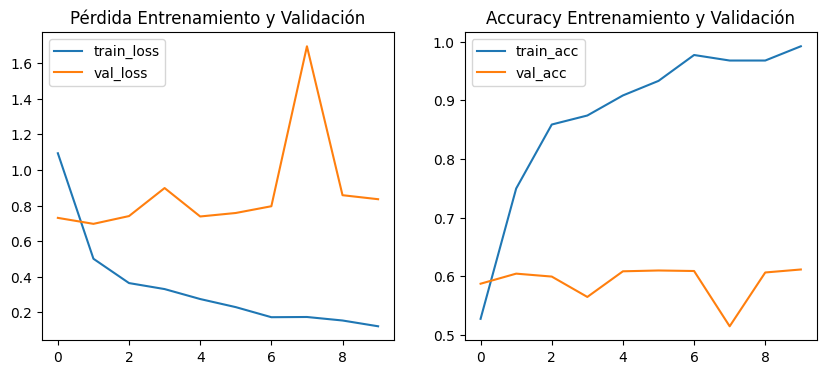

In [ ]:
import auxiliar as aux

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model_glove.parameters(),lr=1e-3)
print("Entrenando modelo con GloVe congelado...")
history_glove = aux.train_model(model_glove, epochs=10, train_loader=train1_loader,
                                 val_loader=val1_loader, loss_fn=criterion, optimizer=optimizer, device=device)

aux.plot_history(history_glove)

El entrenamiento ha sido muy rápido, y el accuracy en train obtenido es muy bueno, pero en validación se comporta muy mal. El modelo está sobreajustando demasiado.

El modelo se sobreajusta muy rápido, algo que no es extraño teniendo en cuenta el tamaño reducido del conjunto de entrenamiento. Consecuentemente, la validación tiene una alta varianza y apenas supera el 63% en el mejor de los casos.

Observa que, debido a la selección aleatoria del pequeño conjunto de entrenamiento, los resultados pueden variar mucho si se vuelve a ejecutar el procedimiento.

También podemos intentar realizar el entrenamiento sin haber precargado una inmersión y sin congelar la capa de inmersión. Es decir, aprendiendo la inmersión específica de la tarea que estamos llevando a cabo. Esta opción, como comentamos, suele ser mejor si se dispone de los recursos computacionales necesarios y de muchos datos, pero nosotros lo entrenamos únicamente con 2000 muestras.

## 3. Usando Convolución 1D

Las convoluciones 1D son excelentes para encontrar patrones locales en secuencias de texto. En PyTorch se puede usar una convnet 1D a través de la capa `Conv1D`, que tiene una interfaz muy similar a `Conv2D`. Toma como entrada tensores 3D con forma `(samples, features, time)` y también devuelve tensores 3D de forma similar. La ventana de convolución es una ventana 1D en el eje temporal (es decir, eje 2, *time*, en el tensor de entrada).

Las convnets 1D están estructuradas de la misma manera que sus versiones 2D que ya hemos utilizado en módulo 5: consisten en una pila de capas `Conv1D` y `MaxPooling1D`, terminando eventualmente en una capa de `globalPooling` o una capa `Flatten`, convirtiendo las salidas 3D en salidas 2D, permitiendo añadir una o más capas `Dense` al modelo, para hacer clasificación o regresión.

Una diferencia, sin embargo, es el hecho de que podemos permitirnos el lujo de usar ventanas de convolución más grandes con convnets 1D. De hecho, con una capa de convolución 2D, una ventana de convolución 3x3 contiene vectores con `3*3 = 9` características, pero con una capa de convolución 1D, una ventana de convolución de tamaño 3 sólo contendría vectores con 3 características. De esta manera podemos permitirnos fácilmente ventanas de convolución 1D de tamaño 7 o 9.

**Importante:** PyTorch espera que la dimensión de los canales (el embedding) esté en la segunda posición: `(Batch, Channel, Length)`, mientras que la salida del embedding es `(Batch, Length, Channel)`. Usaremos `.permute()` para corregirlo.

Este es nuestro ejemplo de convneto 1D para el conjunto de datos IMDB:

Entrenando CNN 1D...


/usr/local/lib64/python3.9/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch [00/10], Train Loss: 0.7001, Validation Loss: 0.6966, Train Accuracy: 0.5278, Validation Accuracy: 0.5027
Epoch [01/10], Train Loss: 0.6759, Validation Loss: 0.7497, Train Accuracy: 0.5605, Validation Accuracy: 0.4988
Epoch [02/10], Train Loss: 0.6573, Validation Loss: 0.6366, Train Accuracy: 0.6081, Validation Accuracy: 0.6482
Epoch [03/10], Train Loss: 0.6016, Validation Loss: 0.6394, Train Accuracy: 0.6845, Validation Accuracy: 0.6230
Epoch [04/10], Train Loss: 0.5616, Validation Loss: 0.5919, Train Accuracy: 0.7143, Validation Accuracy: 0.6852
Epoch [05/10], Train Loss: 0.5023, Validation Loss: 0.6464, Train Accuracy: 0.7609, Validation Accuracy: 0.6422
Epoch [06/10], Train Loss: 0.4787, Validation Loss: 0.5720, Train Accuracy: 0.7718, Validation Accuracy: 0.7044
Epoch [07/10], Train Loss: 0.4258, Validation Loss: 0.5718, Train Accuracy: 0.8130, Validation Accuracy: 0.7064
Epoch [08/10], Train Loss: 0.3949, Validation Loss: 0.5807, Train Accuracy: 0.8244, Validation Accuracy:

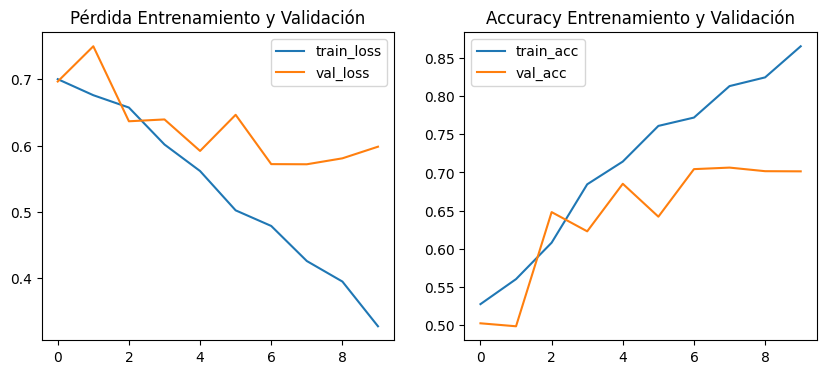

In [18]:
class Conv1DModel(nn.Module):
    def __init__(self, embedding_matrix, max_len):
        super(Conv1DModel, self).__init__()

        num_embeddings, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.embedding.weight.requires_grad = False 
        
        # Conv1D: in_channels=embedding_dim
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=7)
        self.pool = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=7)
        
        # Global Max Pooling 
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        
        self.fc = nn.Linear(32, 1)
        
    def forward(self, x):
        # x: (Batch, Length)
        x = self.embedding(x) 
        # x: (Batch, Length, Emb_Dim)
        
        # PERMUTAR para Conv1d: (Batch, Emb_Dim, Length)
        x = x.permute(0, 2, 1) 
        
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        
        x = self.global_pool(x) # (Batch, 32, 1)
        x = x.squeeze(-1)       # (Batch, 32)
        
        return torch.sigmoid(self.fc(x))

# Usamos los mismos datos que en GloVe (longitud 100) pero con embeddings entrenables
model_conv = Conv1DModel(embedding_matrix, maxlen).to(device)

print("Entrenando CNN 1D...")
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model_conv.parameters(),lr=1e-3)

history_conv = aux.train_model(model_conv, epochs=10, train_loader=train1_loader,
                                 val_loader=val1_loader, loss_fn=criterion, optimizer=optimizer, device=device)

aux.plot_history(history_conv)

Veremos, cuando hagamos uso de redes recurrentes como la LSTM, que el tiempo de entrenamiento es muy alto. Sin embargo, el tiempo de ejecución de una Conv1D es más rápido, tanto en la CPU como en la GPU (aunque la velocidad exacta variará mucho dependiendo de la configuración).

Apenas conseguimos un 69% de accuracy en validación, un valor muy bajo que nos indica que en efecto trabajar con tan pocos ejemplos de entrenamiento lo convierte en una tarea dura.

Vamos a intentarlo de nuevo con más ejemplos, usemos el dataset IMDB que nos provee Keras, ya pre-tokenizado. Pongamos una capa de Embedding vacía.

**Ejercicio**: Como la convolución 1D es una operación muy rápida, utiliza ahora el dataset completo. Redefine las variables Dataset y Dataloader con las variables `x_train`, `y_train`, `x_test`, `y_test`, y prueba de nuevo a entrenar una nueva instancia del mismo modelo. Para combatir el sobreajuste, prueba a añadir regularización L2 al optimizador.

In [ ]:
train2_ds = FIXME
val2_ds = FIXME

batch_size = 32
train2_loader = FIXME
val2_loader = FIXME


model_conv2 = FIXME

print("Entrenando CNN 1D...")
criterion = nn.BCELoss()
optimizer = optim.RMSprop(FIXME)

history_conv2 = aux.train_model(FIXME, epochs=10, train_loader=FIXME,
                                 val_loader=FIXME, loss_fn=criterion, optimizer=optimizer, device=device)

aux.plot_history(history_conv2)

Entrenando CNN 1D...
Epoch [00/10], Train Loss: 0.6150, Validation Loss: 0.5482, Train Accuracy: 0.6516, Validation Accuracy: 0.7234
Epoch [01/10], Train Loss: 0.5310, Validation Loss: 0.5167, Train Accuracy: 0.7360, Validation Accuracy: 0.7430
Epoch [02/10], Train Loss: 0.5130, Validation Loss: 0.5488, Train Accuracy: 0.7444, Validation Accuracy: 0.7132
Epoch [03/10], Train Loss: 0.5060, Validation Loss: 0.5780, Train Accuracy: 0.7498, Validation Accuracy: 0.6881
Epoch [04/10], Train Loss: 0.4983, Validation Loss: 0.5487, Train Accuracy: 0.7542, Validation Accuracy: 0.7077
Epoch [05/10], Train Loss: 0.4975, Validation Loss: 0.7326, Train Accuracy: 0.7563, Validation Accuracy: 0.6081
Epoch [06/10], Train Loss: 0.4899, Validation Loss: 0.4926, Train Accuracy: 0.7601, Validation Accuracy: 0.7536
Epoch [07/10], Train Loss: 0.4900, Validation Loss: 0.6231, Train Accuracy: 0.7598, Validation Accuracy: 0.6725
Epoch [08/10], Train Loss: 0.4847, Validation Loss: 0.6280, Train Accuracy: 0.7642,

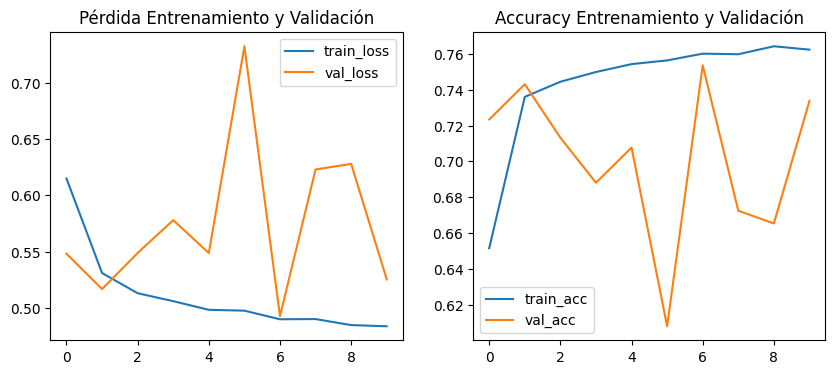

In [19]:
# Solución
train2_ds = IMDBDataset(x_train, y_train)
val2_ds = IMDBDataset(x_test, y_test)

batch_size = 32
train2_loader = DataLoader(train2_ds, batch_size=batch_size, shuffle=True)
val2_loader = DataLoader(val2_ds, batch_size=batch_size)


model_conv2 = Conv1DModel(embedding_matrix, maxlen).to(device)

print("Entrenando CNN 1D...")
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model_conv2.parameters(),lr=1e-3,weight_decay=1e-2)

history_conv2 = aux.train_model(model_conv2, epochs=10, train_loader=train2_loader,
                                 val_loader=val2_loader, loss_fn=criterion, optimizer=optimizer, device=device)

aux.plot_history(history_conv2)

Ahora conseguimos un rendimiento mucho mejor, similar al obtenido al comienzo de la práctica. Jugando con la arquitectura y los hiperparámetros podríamos conseguir una mejora sustancial.

## 4. Usando Redes Recurrentes

### 4.1. Capa `nn.RNN`

Vamos a probar ahora otro tipo de capa, una de la más empleadas para secuencias, y es la capa recurrente. Como el resto de capas de PyTorch, `nn.RNN` procesa batches de secuencias, lo que quiere decir que toma como entrada algo de la forma `(batch_size, timesteps, input_features)`.

Esta capa devuelve dos salidas. Para cada secuencia de entrada en el batch, devuelve:
1. la secuencia completa de salidas (un tensor de tamaño `(batch_size, timesteps, output_features)`) y
2. la última salida del procesamiento de la secuencia de entrada (un tensor de tamaño `(batch_size, output_features)`). 

Podemos elegir una u otra salida. Además, la capa permite a su vez apilar más de una RNN, según el atributo `num_layers`. Por supuesto, estas capas se pueden combinar con cualquier otra de PyTorch, eligiendo o bien la primera o la segunda salida, según la complejidad deseada.

In [23]:
class SimpleRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim):
        super(SimpleRNNModel, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.embedding.weight.requires_grad = False 
        # batch_first=True para recibir (batch, seq, features)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch_size, seq_len)
        x = self.embedding(x)
        
        # rnn devuelve (output, hidden)
        # output contiene las salidas de cada paso de tiempo
        # hidden es el estado oculto final
        _, hidden = self.rnn(x)
        
        # hidden shape: (1, batch_size, hidden_dim)
        # Quitamos la dimensión de capas con squeeze(0)
        out = hidden.squeeze(0)
        
        out = self.fc(out)
        return self.sigmoid(out)

model_rnn = SimpleRNNModel(embedding_matrix, 32).to(device)
print(model_rnn)

SimpleRNNModel(
  (embedding): Embedding(10001, 100)
  (rnn): RNN(100, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Si la celda anterior te da un error de versiones de CUDNN, ejecuta las siguientes líneas y prueba de nuevo:
# import os
# if 'LD_LIBRARY_PATH' in os.environ:
#     del os.environ['LD_LIBRARY_PATH']

Epoch [00/10], Train Loss: 0.6910, Validation Loss: 0.6812, Train Accuracy: 0.5277, Validation Accuracy: 0.5728
Epoch [01/10], Train Loss: 0.6889, Validation Loss: 0.6930, Train Accuracy: 0.5422, Validation Accuracy: 0.5024
Epoch [02/10], Train Loss: 0.6881, Validation Loss: 0.6928, Train Accuracy: 0.5403, Validation Accuracy: 0.5054
Epoch [03/10], Train Loss: 0.6895, Validation Loss: 0.6858, Train Accuracy: 0.5360, Validation Accuracy: 0.5634
Epoch [04/10], Train Loss: 0.6823, Validation Loss: 0.6840, Train Accuracy: 0.5626, Validation Accuracy: 0.5781
Epoch [05/10], Train Loss: 0.6855, Validation Loss: 0.6913, Train Accuracy: 0.5555, Validation Accuracy: 0.5323
Epoch [06/10], Train Loss: 0.6871, Validation Loss: 0.6930, Train Accuracy: 0.5429, Validation Accuracy: 0.5017
Epoch [07/10], Train Loss: 0.6830, Validation Loss: 0.6742, Train Accuracy: 0.5578, Validation Accuracy: 0.5699
Epoch [08/10], Train Loss: 0.6797, Validation Loss: 0.6880, Train Accuracy: 0.5712, Validation Accuracy:

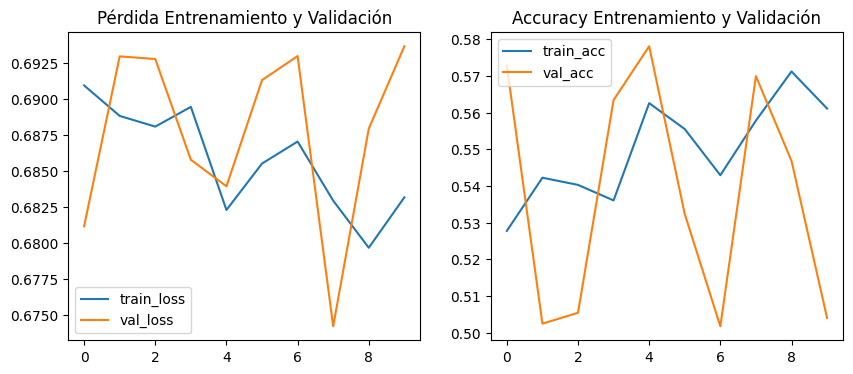

In [24]:
optimizer = optim.RMSprop(model_rnn.parameters(),lr=1e-3,weight_decay=1e-2)

history_rnn = aux.train_model(model_rnn, epochs=10, train_loader=train2_loader,
                                 val_loader=val2_loader, loss_fn=criterion, optimizer=optimizer, device=device)

aux.plot_history(history_rnn)

Vemos que las capas `nn.RNN` no llegan a ajustar, nos quedamos con un modelo de un 50% de acierto (básicamente, un modelo aleatorio). . Parte del problema, por supuesto, es que la capa `RNN` no es suficientemente buena para procesar secuencias largas, ya que sufre el problema del **desvanecimiento del gradiente** habitual en capas profundas, lo que significa que apenas puede recordar estados que estén muy atrás en el tiempo. 

A continuación veremos otro tipo de capa recurrente que intenta evitar este problema.

### 4.2. Capa `nn.LSTM`

Ahora cambiamos la capa `nn.RNN` por una `nn.LSTM` para manejar mejor las dependencias a largo plazo. La principal diferencia con la capa RNN es que además de devolver lo que la anterior, también devuelve el último estado de cell de la capa LSTM, con forma `(batch_size, cell_features)`. Fíjate que cambia muy poco respecto a nn.RNN:

In [27]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim):
        super(LSTMModel, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.embedding.weight.requires_grad = False 
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        # LSTM devuelve (output, (hidden, cell))
        _, (hidden, cell) = self.lstm(x)
        # Usamos el último estado hidden
        out = hidden.squeeze(0)
        out = self.fc(out)
        return self.sigmoid(out)

model_lstm = LSTMModel(embedding_matrix, 32).to(device)
print(model_lstm)

LSTMModel(
  (embedding): Embedding(10001, 100)
  (lstm): LSTM(100, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch [00/10], Train Loss: 0.6919, Validation Loss: 0.6921, Train Accuracy: 0.5247, Validation Accuracy: 0.5104
Epoch [01/10], Train Loss: 0.6914, Validation Loss: 0.6902, Train Accuracy: 0.5300, Validation Accuracy: 0.5372
Epoch [02/10], Train Loss: 0.6754, Validation Loss: 0.6908, Train Accuracy: 0.5886, Validation Accuracy: 0.5192
Epoch [03/10], Train Loss: 0.6667, Validation Loss: 0.6660, Train Accuracy: 0.6101, Validation Accuracy: 0.5981
Epoch [04/10], Train Loss: 0.6012, Validation Loss: 0.5811, Train Accuracy: 0.6942, Validation Accuracy: 0.6967
Epoch [05/10], Train Loss: 0.5519, Validation Loss: 0.5434, Train Accuracy: 0.7345, Validation Accuracy: 0.7361
Epoch [06/10], Train Loss: 0.5326, Validation Loss: 0.5347, Train Accuracy: 0.7459, Validation Accuracy: 0.7381
Epoch [07/10], Train Loss: 0.5211, Validation Loss: 0.7218, Train Accuracy: 0.7511, Validation Accuracy: 0.6340
Epoch [08/10], Train Loss: 0.5146, Validation Loss: 0.5567, Train Accuracy: 0.7546, Validation Accuracy:

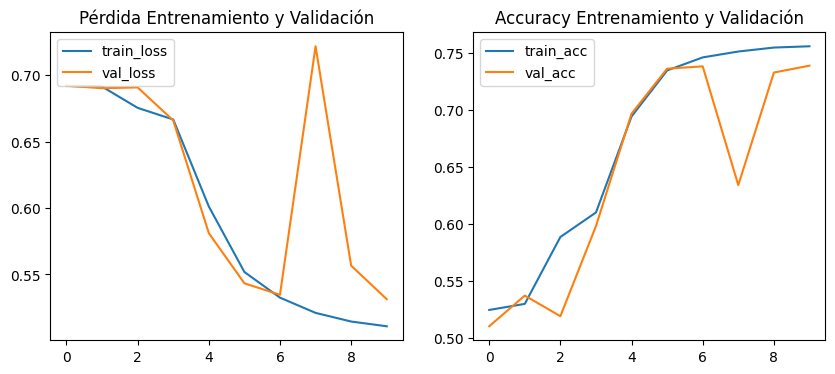

In [28]:
optimizer = optim.RMSprop(model_lstm.parameters(),lr=1e-3,weight_decay=1e-2)

history_lstm = aux.train_model(model_lstm, epochs=10, train_loader=train2_loader,
                                 val_loader=val2_loader, loss_fn=criterion, optimizer=optimizer, device=device)

aux.plot_history(history_lstm)

Alcanzamos un 73% de accuracy, que supera el de la red con `nn.RNN` ya que `nn.LSTM` sufre menos el efecto del desvanecimiento, y aproximadamente igual (quizás un poco mejor) que el de la red densa. 

Sin embargo, esta solución con LSTM requiere mucha más potencia computacional que la densa, y los resultados no son tan llamativos. Por supuesto, una razón puede ser que no hemos hecho ningún ajuste fino de los parámetros de la red (por ejemplo, la dimensión de inmersión), por lo que quizás no estamos obteniendo el rendimiento que podíamos. Pero quizás la razón principal es que analizar la estructura completa de las opiniones quizás no sea tan importante para evaluar un problema de análisis de sentimientos, y quizás solo sea suficiente con saber qué palabras, y con qué frecuencia, aparecen en la opinión.

Pero hay problemas mucho más duros que este para los que las redes densas no proporcionarían una solución suficientemente buena, y para los que las LSTM sí funcionan bien, como, por ejemplo, la traducción automática.